In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from lmfit import Model
import os
from math import ceil

## Set data paths

In [2]:
data_path = 'Sample data'
spectroscopy_path = os.path.join(data_path, 'Spectroscopy')
loading_path = os.path.join(data_path, 'Loading Time')
temperature_path = os.path.join(data_path, 'Release and Recapture')

## Functions to parse the data

In [77]:
def get_txt_csv(path):
    files = os.listdir(path)
    file_names = [ file for file in files if file.endswith( ('.txt','.TXT','.CSV','.csv') ) ]
    file_paths = [os.path.join(path, file) for file in file_names]
    return file_names, file_paths

def make_oscilloscope_df(path):
    file_names, file_paths = get_txt_csv(path)
    dfs = []
    for file_path, file_name in zip(file_paths, file_names):
        df = pd.read_csv(file_path, header=None)
        df.drop([0,1,2,5], axis=1, inplace=True)
#         df = df.astype(np.float64)
#         df.index = df.index.astype(np.float64)
        df.set_index(3, inplace=True)
        df.index.name = 'time [s]'
        df.columns = [file_name[:-4]]
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    return dfs

def make_spectroscopy_df(path):
    pass

def plot_dfs(dfs):
    plot_columns = ceil(len(dfs)/4)
    fig, axes = plt.subplots(plot_columns,4, figsize=(15, plot_columns*2), facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, df in enumerate(dfs):
        axes[i].plot(df.index,df.values, '.')
    return fig, axes

## Analysing loading curves

### 1 - Starting point

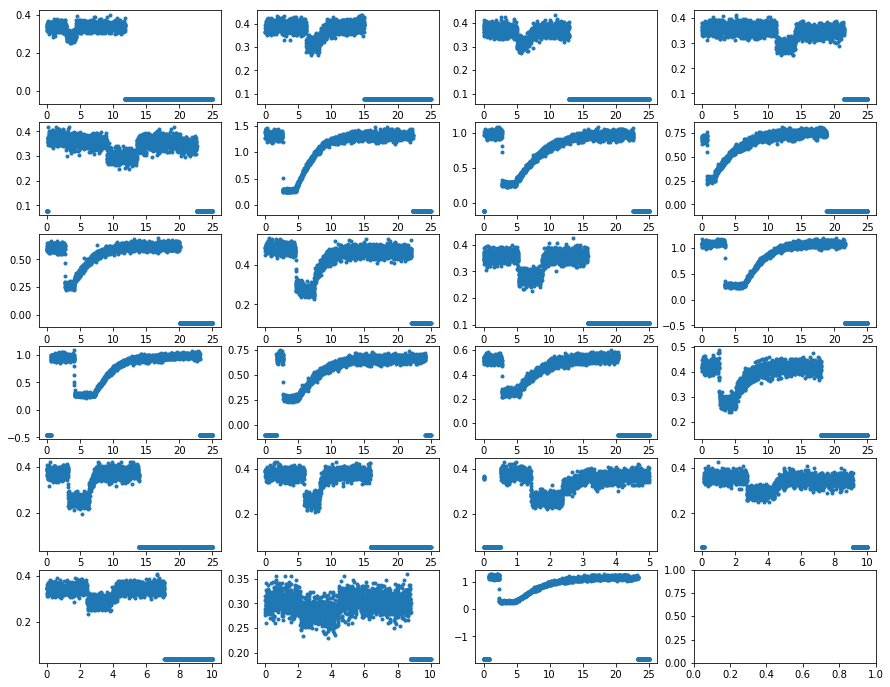

In [171]:
dfs = make_oscilloscope_df(loading_path)
# df.plot(marker='.', figsize=(14,20), subplots=True, sharex=False, layout=(7,4));
fig, axes = plot_dfs(dfs)
plt.show(fig)

### 2 - Filtering values that are equal to the minimum value

In [172]:
def filter_loading(dfs, rolling=1):
    for i, df in enumerate(dfs):
        dfs[i] = df[df != df.min()].rolling(window=rolling, center=True).mean().dropna()
    return dfs

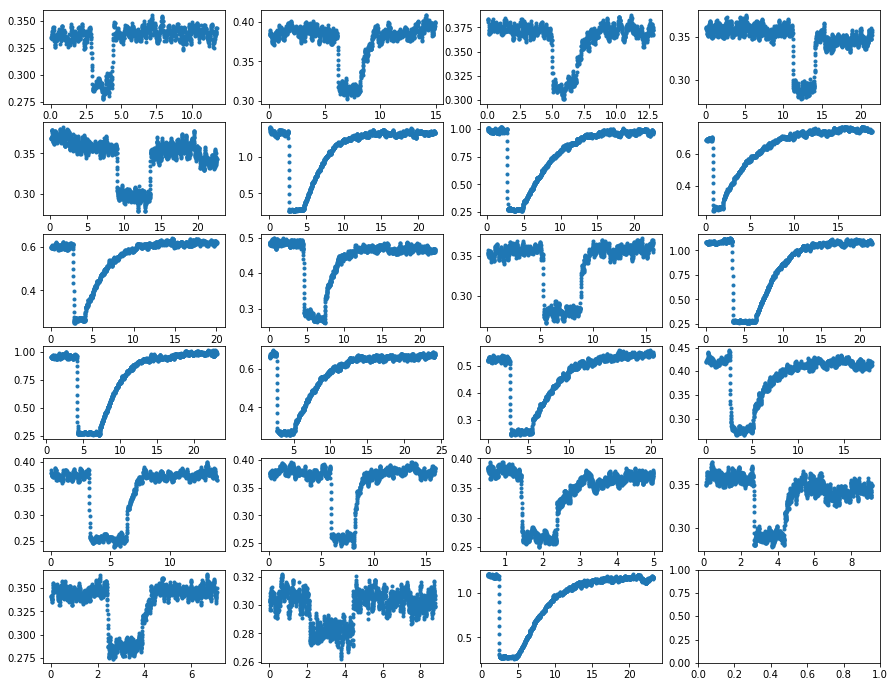

In [173]:
dfs = filter_loading(dfs, rolling=10)
fig, axes = plot_dfs(dfs)
plt.show(fig)

### 3 - Fitting loading curves

{'amp': [],
 'file': ['TEK0000',
  'TEK0001',
  'TEK0002',
  'TEK0003',
  'TEK0004',
  'TEK0005',
  'TEK0006',
  'TEK0007',
  'TEK0008',
  'TEK0009',
  'TEK0010',
  'TEK0011',
  'TEK0012',
  'TEK0013',
  'TEK0014',
  'TEK0015',
  'TEK0016',
  'TEK0017',
  'TEK0018',
  'TEK0019',
  'TEK0020',
  'TEK0021',
  'TEK0022'],
 'redchi': [],
 'tau': []}

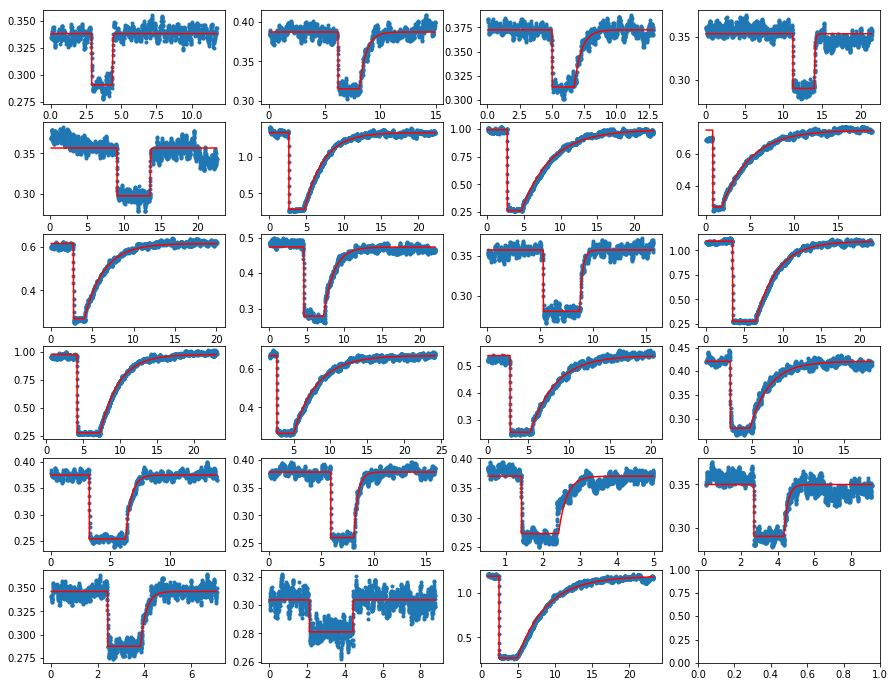

In [200]:
from lmfit import Parameters, fit_report, minimize

def loading_residual(pars, x , data=None):
    vals = pars.valuesdict()
    v1 = vals['v1']
    v2 = vals['v2']
    t0 = vals['t0']
    dt = vals['dt']
    tau = vals['tau']
    
    model = v2+(v1-v2)*(1-np.exp(-np.abs((x-t0-dt)/tau)))
    model[x <= t0+dt] = v2
    model[x <= t0] = v1
#     print(model)
    if data is None:
        return model
    return model - data


def fit_loading_dfs(dfs):
    fit_data = {
        'file': [df.columns[0] for df in dfs],
        'amp': [],
        'amp_std': [],
        'tau': [],
        'tau_std': [],
        'redchi': [],
    }
    for i, df in enumerate(dfs):
        x = df.index.values
        y = df.iloc[:,0].values
        
        # predicting parameters
        v1 = np.mean(y[:10])
        v2 = np.min(y)
        tmin = np.min(x)
        tmax = np.max(x)
        
        p = Parameters()
        p.add('v1', value=v1)
        p.add('v2', value=v2, min=np.min(y), max=np.min(y)+0.03)
        p.add('t0', value=1, min=tmin, max=tmax)
        p.add('dt', value=2, min=1, max=tmax)
        p.add('tau', value=5)
        
        mi = minimize(loading_residual, p, args=(x,), kws={'data': y}, method='powell')
        dfs[i]['best fit'] = loading_residual(mi.params, x)
        
        
        
    return dfs, fit_data

def plot_dfs_with_fits(dfs):
    plot_columns = ceil(len(dfs)/4)
    fig, axes = plt.subplots(plot_columns,4, figsize=(15, plot_columns*2), facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, df in enumerate(dfs):
        axes[i].plot(df.index,df.iloc[:,0].values, '.')
#         axes[i].plot(df.index,df['init fit'].values, 'k--')
        axes[i].plot(df.index,df['best fit'].values, 'r-')
    return fig, axes

dfs_fit, fit_data = fit_loading_dfs(dfs)
fig, axes = plot_dfs_with_fits(dfs_fit)
fit_data

In [199]:
dfs[0].columns[0]

'TEK0000'

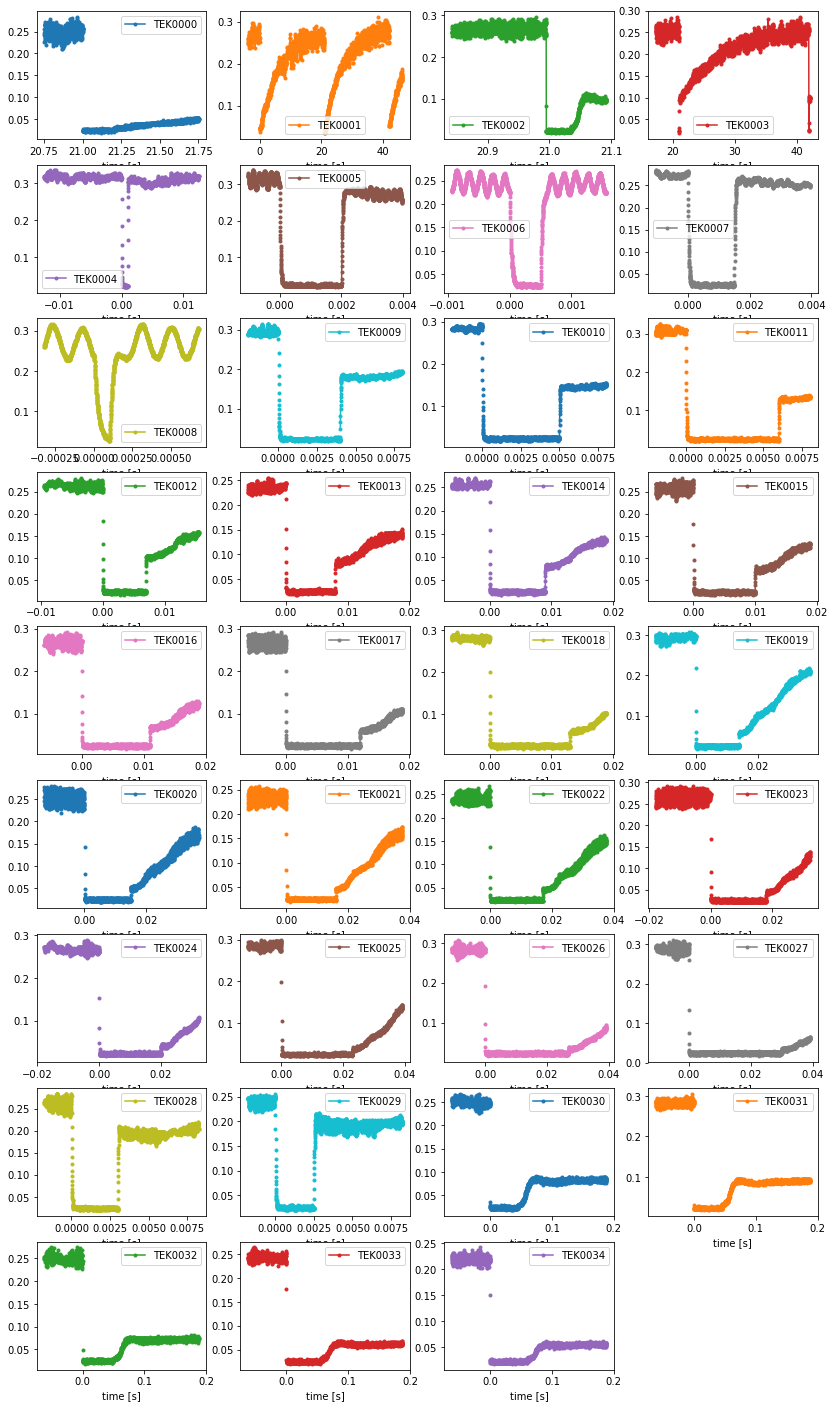

In [195]:
df, dataframes = make_oscilloscope_df(temperature_path)
df.plot(marker='.', figsize=(14,25), subplots=True, layout=(9,4), sharex=False);